In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [39]:
# выгружаем данные
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-allaberganov/Statistics/Lesson_9/hw_bootstrap.csv', sep = ';')
df = df.drop(columns = {'Unnamed: 0'})

In [35]:
df

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control
...,...,...
995,1000,Treatment
996,1200,Treatment
997,1500,Treatment
998,2000,Treatment


In [36]:
# так как значения в колонке "value" имели тир object, переводим их в float
df['value'] = df['value'].apply(lambda x: x.replace(',', '.'))
df['value'] = df['value'].astype(float)

In [37]:
df.describe()

,value
count,1000.000000
mean,18.674183
std,132.135045
min,6.436541
25%,9.414051
50%,10.020862
75%,10.669292
max,3000.000000


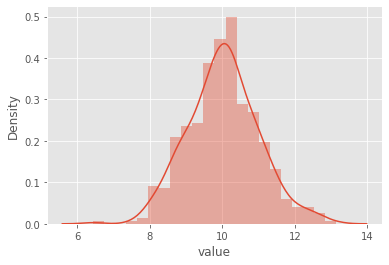

In [5]:
# изучаем распределение контрольной группы. данная группа имеет нормальное распределение
sns.distplot(df.query("experimentVariant == 'Control'")['value'])

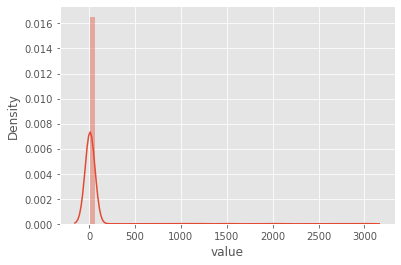

In [6]:
# изучаем распределение тестовой группы, оно является ненормальным 
sns.distplot(df.query("experimentVariant == 'Treatment'")['value'])

In [7]:
mannwhitneyu(df.query("experimentVariant == 'Treatment'")['value'],  df.query("experimentVariant == 'Control'")['value'], use_continuity=True, alternative='two-sided')

MannwhitneyuResult(statistic=125810.5, pvalue=0.8592148582485579)

Так как, мы получаем p > 0.05 тест Манни-Уитни говорит нам о том, что между группами отсутствует значемые различия.

In [8]:
data_column_1 = df.query("experimentVariant == 'Control'")['value']
data_column_2 = df.query("experimentVariant == 'Treatment'")['value']

In [18]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [19]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

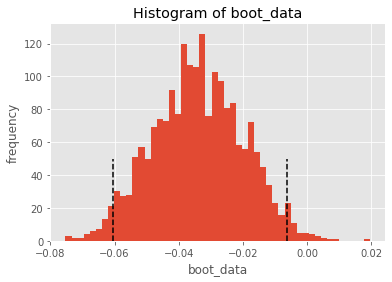

In [20]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [21]:
booted_data["p_value"]

0.015967841910844854

In [22]:
booted_data["ci"]

,0
0.025,-0.060541
0.975,-0.006225


In [23]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [24]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df = pd.DataFrame({"x": x, "y": y})

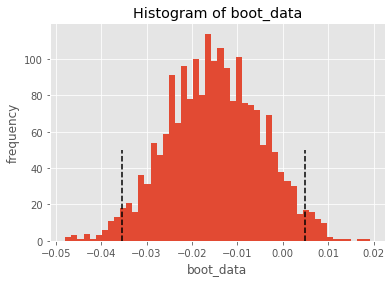

In [25]:
booted_data = get_bootstrap(df.x, df.y, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [26]:
booted_data["p_value"]

0.14835422845115456

In [27]:
booted_data["ci"]

,0
0.025,-0.035361
0.975,0.004872


Таким образом, мы можем сделать следующие выводы. 

Как мы видим из результата теста Манни-Уитни и расчетов бутстрап по медиане, значемые различия между выборками отсутствуют. Но, расчеты бутстрапа по среднему говорят об обратном, то есть они подверждают гипотезу, что все таки значемые различия существуют.
Однако, когда мы смотрим на график распределения treatment группы, то можем увидеть, что распределение не нормальное и существуют выбросы, которые тянут хвост в правую сторону. Принимая это во внимание, мы не можем принимать результаты бутстрапа по среднему, хотя p-value показывает значемые результаты. Когда, мы имеем аномально больше выборсы (75 перцинтиль показывает значение равное 10, а максимальное значение 3000), среднее значение будет уходить вправо, поэтому здесь правильным подходом будет расчет по медиане.   